# NFL Baseline

# import libraries

In [1]:
# general
import os
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import time
import math

import sys
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
import timm


# deep learning
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# loss metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix

# warningの表示方法の設定
import warnings
warnings.filterwarnings("ignore")

# Set Configurations

In [2]:
kaggle = False

class CFG:
    if kaggle:
        BASE_DIR = "/kaggle/input/nfl-player-contact-detection"
    else:
        BASE_DIR = "/workspace/input"
        FRAME_IMAGE_DIR = "/workspace/input/train_images"
    TRAIN_HELMET_CSV = os.path.join(BASE_DIR, "train_baseline_helmets.csv")
    TRAIN_TRACKING_CSV = os.path.join(BASE_DIR, "train_player_tracking.csv")
    TRAIN_VIDEO_META_CSV = os.path.join(BASE_DIR, "train_video_metadata.csv")
    TRAIN_LABEL_CSV = os.path.join(BASE_DIR, "train_labels.csv")
    TARGET_CSV = os.path.join(BASE_DIR, "target_fillna0_3.csv")
    

    # data config    
    img_size = (224, 224)
    batch_size = 64
    num_workers = 0
    n_fold = 1

    # model config
    model_name = "tf_efficientnet_b0"
    out_features = 1
    inp_channels= 3
    pretrained = True
    model_dir = os.path.join(os.path.dirname(BASE_DIR), "model")
    if kaggle:
        model_dir = "/kaggle/working"
    
    # learning config
    n_epoch = 20
    lr = 1e-6
    T_max = 10
    min_lr = 1e-7
    weight_decay = 1e-6
    
    # etc
    print_freq = 100
    random_seed = 21


# Utils

In [3]:
def seed_everything(seed=CFG.random_seed):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Dataset Utils

In [5]:
def get_snap_frame(row):
    elaped_time_start2snap = row.snap_time - row.start_time
    elaped_seconds = elaped_time_start2snap.seconds
    snap_frame = elaped_seconds*59.95
    return snap_frame

In [6]:
def set_inimg_window(crop_area, img_size=(720, 1280)):
    left, top, right, bot = crop_area
    # set crop area (area size in img size)
    crop_left = max(0, left)
    crop_top = max(0, top)
    if crop_left != left:   right = right - left
    if crop_top != top:    bot = bot - top
    crop_bot = min(img_size[0], bot)
    crop_right = min(img_size[1], right)
    if crop_bot != bot:    crop_top = crop_top - (bot - img_size[0])
    if crop_right != right:   crop_left = left - (right - img_size[1])
    
    return [crop_left, crop_top, crop_right, crop_bot]

In [7]:
def make_player_mask(img, helmet_pos, img_size=(720, 1280, 3), alpha=0.3):
    crop_size=[-helmet_pos[2], -helmet_pos[3], helmet_pos[2]*3, helmet_pos[3]*6] # helmetの大きさによってplayerの範囲も変更
    base_area = np.array(helmet_pos) + np.array(crop_size) # [left, top, width, height]
    # set players area
    palyer_area = [base_area[0],  base_area[1], base_area[0] + base_area[2], base_area[1] + base_area[3]]
    palyer_area = set_inimg_window(palyer_area)
    mask = np.zeros(img_size, dtype=np.uint8)
    cv2.rectangle(mask, [palyer_area[0], palyer_area[1]], [palyer_area[2], palyer_area[3]], (255, 255, 255), -1)
    mask = np.clip(mask, 0, 1).astype(np.uint8)
    return mask

In [8]:
def get_1player_croparea(helmet_pos, img_size=(720, 1280)):
    crop_size=[-helmet_pos[2]*3, -helmet_pos[3]*4, helmet_pos[2]*6, helmet_pos[3]*6] # helmetの大きさによってplayerの範囲も変更
    players_area = np.array(helmet_pos) + np.array(crop_size) # [left, top, width, height]
    # set players area
    crop_area = [players_area[0],  players_area[1], players_area[0] + players_area[2], players_area[1] + players_area[3]]
    crop_area = set_inimg_window(crop_area)
    return crop_area

In [9]:
def get_2player_croparea(helmet1_pos, helmet2_pos, img_size=(720, 1280)):
    player1_crop_size=[-10, -10, helmet1_pos[2]*4, helmet1_pos[3]*4] # helmetの大きさによってplayerの範囲も変更
    player2_crop_size=[-10, -10, helmet2_pos[2]*4, helmet2_pos[3]*4] # helmetの大きさによってplayerの範囲も変更
    player1_area = np.array(helmet1_pos) + np.array(player1_crop_size) # [left, top, width, height]
    player2_area = np.array(helmet2_pos) + np.array(player2_crop_size) # [left, top, width, height]
    # [left, top, width, height] => [left, top, right, bot]
    player1_crop_area = np.array([player1_area[0], player1_area[1], player1_area[0]+player1_area[2], player1_area[1]+player1_area[3]]) # [left, top, right, bot]
    player2_crop_area = np.array([player2_area[0], player2_area[1], player2_area[0]+player2_area[2], player2_area[1]+player2_area[3]]) # [left, top, right, bot]
    # get min max for set pos in img
    area_min = np.min(np.array([player1_crop_area, player2_crop_area]), axis=0)
    area_max = np.max(np.array([player1_crop_area, player2_crop_area]), axis=0)
    crop_area = [area_min[0], area_min[1], area_max[2], area_max[3]]
    crop_area = set_inimg_window(crop_area)
    return crop_area

In [10]:
def mask_blend(img, mask):
    img = np.clip(img, 0, 255).astype(np.uint8)
    mask = np.clip(mask, 0, 1).astype(np.uint8)
    img = img*mask
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [11]:
def search_helmet(helmet_df, player, frame):
    for diff_frame in range(5):
        read_frame = frame + diff_frame
        player_helmet = helmet_df.query('nfl_player_id==@player and frame==@read_frame')
        if len(player_helmet) > 0:
            return player_helmet
        read_frame = frame - diff_frame
        player_helmet = helmet_df.query('nfl_player_id==@player and frame==@read_frame')
        if len(player_helmet) > 0:
            return player_helmet
    return []

# Read Data

In [12]:
target_df = pd.read_csv(CFG.TARGET_CSV)

In [13]:
target_df.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame,game_frame,game_frame_player_1,...,E_top_2,E_height_2,S_left_1,S_width_1,S_top_1,S_height_1,S_left_2,S_width_2,S_top_2,S_height_2
0,58168_003392_0_38590_41944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41944,0,298,58168_003392_298,58168_003392_298_38590,...,291.0,34.0,468.0,13.0,372.0,18.0,511.0,13.0,415.0,15.0
1,58168_003392_0_38590_47944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,47944,0,298,58168_003392_298,58168_003392_298_38590,...,315.0,17.0,468.0,13.0,372.0,18.0,530.0,14.0,351.0,17.0
2,58168_003392_0_38590_44822,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,44822,0,298,58168_003392_298,58168_003392_298_38590,...,254.0,33.0,468.0,13.0,372.0,18.0,427.0,14.0,384.0,19.0
3,58168_003392_0_38590_39947,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,39947,0,298,58168_003392_298,58168_003392_298_38590,...,281.0,34.0,468.0,13.0,372.0,18.0,473.0,15.0,342.0,18.0
4,58168_003392_0_38590_42565,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,42565,0,298,58168_003392_298,58168_003392_298_38590,...,313.0,19.0,468.0,13.0,372.0,18.0,478.0,15.0,400.0,18.0


# each view distance

In [14]:
target_df["E_dis"] = np.sqrt(((target_df["E_left_1"] - target_df["E_left_2"])**2)
                             + ((target_df["E_top_1"] - target_df["E_top_2"])**2))
target_df["S_dis"] = np.sqrt(((target_df["S_left_1"] - target_df["S_left_2"])**2)
                             + ((target_df["S_top_1"] - target_df["S_top_2"])**2))

<AxesSubplot:>

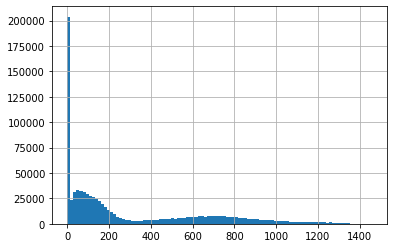

In [15]:
target_df["E_dis"].hist(bins=100)

<AxesSubplot:>

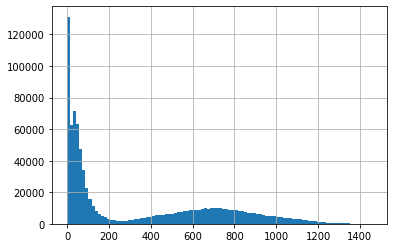

In [16]:
target_df["S_dis"].hist(bins=100)

In [17]:
check_df = target_df[(target_df["E_width_1"]!=0) & (target_df["E_width_2"]!=0) & (target_df["nfl_player_id_2"]!="G")]
check_positive_df = check_df[check_df["contact"]==1]
print(f"data num = {len(check_df)}")
print("check distance")
print(np.max(check_df["E_dis"].values))
print(np.max(check_df["S_dis"].values))

print("check distance (positive sample)")
print(np.max(check_positive_df["E_dis"].values))
print(np.max(check_positive_df["S_dis"].values))

data num = 372022
check distance
1201.2160505088166
1393.621182387811
check distance (positive sample)
752.1096994454998
1320.4620403479987


helmetの距離で判別するのは難しそう？？
速度情報とかも使う必要がありそう・・・

In [18]:
check_positive_df.iloc[np.argmax(check_positive_df["E_dis"].values)]

contact_id             58257_003529_31_48601_53054
game_play                             58257_003529
datetime                 2020-11-22 23:32:51+00:00
step                                            31
nfl_player_id_1                              48601
nfl_player_id_2                              53054
contact                                          1
frame                                          482
game_frame                        58257_003529_482
game_frame_player_1         58257_003529_482_48601
game_frame_player_2         58257_003529_482_53054
x_position_1                                 53.46
y_position_1                                 19.93
x_position_2                                 52.87
y_position_2                                  20.1
players_dis                               0.614003
E_left_1                                     737.0
E_width_1                                      7.0
E_top_1                                      357.0
E_height_1                     

# Save frame images

In [19]:
view = "Endzone"
all_video_start = time.time()
filelist = []

target_game_plays = target_df["game_play"].unique()[:50]
target_videos_num = len(target_game_plays)

for idx, game_play in enumerate(target_game_plays):
    video_id = game_play + "_" + view + ".mp4"
    video_path = os.path.join(CFG.BASE_DIR, "train", video_id)
    print("target video =", video_path)
    start_time = time.time()
    cam = cv2.VideoCapture(video_path)
    target_frames_df = target_df.query('game_play==@game_play')
    target_frames_df = target_frames_df[["game_play", "frame", "game_frame"]]
    target_frames_df = target_frames_df.drop_duplicates(subset="game_frame")
    target_frames_df = target_frames_df.sort_values('frame', ascending=True)
    cam_frame, frame_idx = 0, 0
    target_frames = target_frames_df["frame"].values
    frame = target_frames[frame_idx]
    ret = True
    while ret:
        ret = cam.grab()
        cam_frame += 1
        if cam_frame == frame:
            ret_retrieve, img = cam.retrieve()
            file_id = f"{game_play}_{view}_{frame:05}.png"
            filename = os.path.join(CFG.FRAME_IMAGE_DIR, file_id)
            if not ret_retrieve:
                print("\t cannot read frame", file_id)
                break
            cv2.imwrite(filename, img)
            filelist.append([game_play, frame, filename])
            frame_idx += 1
            if frame_idx >= len(target_frames):
                break
            frame = target_frames[frame_idx]
    if idx%10 == 0:
        elapsed = time.time() - start_time
        print(f"  elapsed time = {elapsed:.3f} sec. [{idx+1}/{target_videos_num}]")
elapsed = (time.time() - all_video_start)/60
print(f"all video elapsed time = {elapsed:.3f} min. [{idx+1}/{target_videos_num}]")

target video = /workspace/input/train/58168_003392_Endzone.mp4
  elapsed time = 5.356 sec. [1/50]
target video = /workspace/input/train/58172_003247_Endzone.mp4
target video = /workspace/input/train/58173_003606_Endzone.mp4
target video = /workspace/input/train/58174_001792_Endzone.mp4
target video = /workspace/input/train/58176_002844_Endzone.mp4
target video = /workspace/input/train/58177_004239_Endzone.mp4
target video = /workspace/input/train/58180_000986_Endzone.mp4
target video = /workspace/input/train/58180_004644_Endzone.mp4
target video = /workspace/input/train/58187_001341_Endzone.mp4
target video = /workspace/input/train/58187_001383_Endzone.mp4
target video = /workspace/input/train/58187_001691_Endzone.mp4
  elapsed time = 10.743 sec. [11/50]
target video = /workspace/input/train/58187_002329_Endzone.mp4
target video = /workspace/input/train/58187_002815_Endzone.mp4
target video = /workspace/input/train/58187_003092_Endzone.mp4
	 cannot read frame 58187_003092_Endzone_00804

In [20]:
# capture = cv.VideoCapture(movie_path)
# for i in range(0, num_frames):
#     ret = capture.grab()
#     if i % 10 == 0:
#         ret, frame = capture.retrieve()
#         # do something with frame

https://www.kaggle.com/competitions/deepfake-detection-challenge/discussion/122328

In [21]:
csvfilename = os.path.join(CFG.BASE_DIR, "saved_frames.csv")
pd.DataFrame(filelist, columns=["game_play", "frame", "file_id"]).to_csv(csvfilename, index=False)